## Dependencies

In [1]:
import re
import warnings
from joblib import dump
import tensorflow_hub as hub
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from tensorflow.keras import Model, optimizers
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout, Concatenate, BatchNormalization, Activation, Average
from tensorflow.keras.callbacks import ReduceLROnPlateau
from googleqa_utilityscript import *


SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## Load data

In [2]:
module_url = '/kaggle/input/universalsentenceencodermodels/universal-sentence-encoder-models/use'
model_path = '/kaggle/working/use.h5'
category_encoder_path = '/kaggle/working/category_encoder.joblib'
scaler_path = '/kaggle/working/scaler.joblib'

hold_out = pd.read_csv('/kaggle/input/googleqa-mldataset/hold-out.csv')
train = hold_out[hold_out['set'] == 'train']
validation = hold_out[hold_out['set'] == 'validation']

print('Train samples: %s' % len(train))
print('Validation samples: %s' % len(validation))
display(train.head())

Train samples: 4863
Validation samples: 1216


,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,set
0,3895,Magento (1.7) Bundled Product with FREE Produc...,I'm looking to create a bundle offer where cus...,Joe,https://magento.stackexchange.com/users/16572,"Since the third item is fixed, you can use sho...",Fabian Schmengler,https://magento.stackexchange.com/users/243,http://magento.stackexchange.com/questions/668...,TECHNOLOGY,...,0.888889,0.666667,1.0,1.0,0.933333,1.000000,0.000000,0.333333,0.888889,train
1,3131,Find router on network,I've just bought a Belkin N+ Wireless Router. ...,Guy,https://superuser.com/users/3248,You likely have the router plugged in to the m...,John T,https://superuser.com/users/1931,http://superuser.com/questions/87212,TECHNOLOGY,...,1.000000,0.666667,1.0,1.0,0.866667,0.666667,0.000000,1.000000,1.000000,train
2,1507,Negatively curved metrics minimizing the lengt...,Good afternoon everyone !\n\nI have the follow...,Selim G,https://mathoverflow.net/users/25511,A very partial answer: by the results of Richa...,Igor Rivin,https://mathoverflow.net/users/11142,http://mathoverflow.net/questions/203422,SCIENCE,...,0.888889,0.333333,1.0,1.0,0.700000,0.333333,0.333333,1.000000,0.888889,train
3,6784,Isn’t the FAQ label obsolete by now?,Don’t get me wrong in the beginning of reading...,Benny Skogberg,https://ux.stackexchange.com/users/4679,Isn’t the FAQ label obsolete by now? \n\nI'd s...,Solracnapod,https://ux.stackexchange.com/users/13153,http://ux.stackexchange.com/questions/18600/is...,TECHNOLOGY,...,0.888889,0.666667,1.0,1.0,0.933333,0.000000,0.000000,0.666667,1.000000,train
4,2135,Changing background image one time on responsi...,The code I'm using is this one \n\nbackground:...,user2141649,https://stackoverflow.com/users/2141649,&lt;!DOCTYPE html&gt;\n&lt;html&gt;\n&lt;head&...,akkimads,https://stackoverflow.com/users/2375373,http://stackoverflow.com/questions/16359492/ch...,STACKOVERFLOW,...,0.888889,0.500000,1.0,1.0,0.800000,1.000000,0.000000,0.000000,0.777778,train


In [3]:
question_target_cols = ['question_asker_intent_understanding','question_body_critical', 'question_conversational', 
                        'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer',
                        'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 
                        'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice',
                        'question_type_compare', 'question_type_consequence', 'question_type_definition', 
                        'question_type_entity', 'question_type_instructions', 'question_type_procedure',
                        'question_type_reason_explanation', 'question_type_spelling', 'question_well_written']
answer_target_cols = ['answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance',
                      'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 
                      'answer_type_reason_explanation', 'answer_well_written']
target_cols = question_target_cols + answer_target_cols

## Pre-process data

In [4]:
text_features = ['question_title', 'question_body', 'answer']

for feature in text_features:
    # Lower
    train[feature] = train[feature].apply(lambda x: x.lower())
    validation[feature] = validation[feature].apply(lambda x: x.lower())
    # Map misspellings
#     train[feature] = train[feature].apply(lambda x: map_misspellings(x))
#     validation[feature] = validation[feature].apply(lambda x: map_misspellings(x))
    # Map contractions
    train[feature] = train[feature].apply(lambda x: map_contraction(x))
    validation[feature] = validation[feature].apply(lambda x: map_contraction(x))
    # Trim text
    train[feature] = train[feature].apply(lambda x: x.strip())
    validation[feature] = validation[feature].apply(lambda x: x.strip())


# Text length
train['question_title_len'] = train['question_title'].apply(lambda x : len(x))
validation['question_title_len'] = validation['question_title'].apply(lambda x : len(x))
train['question_body_len'] = train['question_body'].apply(lambda x : len(x))
validation['question_body_len'] = validation['question_body'].apply(lambda x : len(x))
train['answer_len'] = train['answer'].apply(lambda x : len(x))
validation['answer_len'] = validation['answer'].apply(lambda x : len(x))

# Word count
train['question_title_wordCnt'] = train['question_title'].apply(lambda x : len(x.split(' ')))
validation['question_title_wordCnt'] = validation['question_title'].apply(lambda x : len(x.split(' ')))
train['question_body_wordCnt'] = train['question_body'].apply(lambda x : len(x.split(' ')))
validation['question_body_wordCnt'] = validation['question_body'].apply(lambda x : len(x.split(' ')))
train['answer_wordCnt'] = train['answer'].apply(lambda x : len(x.split(' ')))
validation['answer_wordCnt'] = validation['answer'].apply(lambda x : len(x.split(' ')))

## Train/validation sets

In [5]:
ohe_category = OneHotEncoder(handle_unknown='ignore')
scaler = MinMaxScaler()
ohe_category.fit(train[['category']])

# Train features
X_train_title = train['question_title']
X_train_body = train['question_body']
X_train_answer = train['answer']
X_train_category = ohe_category.transform(train[['category']]).toarray()
X_train_dense = train[['question_title_len', 'question_title_wordCnt', 'question_body_len', 'question_body_wordCnt', 'answer_len', 'answer_wordCnt']]

scaler.fit(X_train_dense)
X_train_dense = scaler.transform(X_train_dense)
X_train = [X_train_title, X_train_body, X_train_answer, X_train_category, X_train_dense]
Y_train = train[target_cols].values

# Validation features
X_valid_title = validation['question_title']
X_valid_body = validation['question_body']
X_valid_answer = validation['answer']
X_valid_category = ohe_category.transform(validation[['category']]).toarray()
X_valid_dense = validation[['question_title_len', 'question_title_wordCnt', 'question_body_len', 'question_body_wordCnt', 'answer_len', 'answer_wordCnt']]

X_valid_dense = scaler.transform(X_valid_dense)
X_valid = [X_valid_title, X_valid_body, X_valid_answer, X_valid_category, X_valid_dense]
Y_valid = validation[target_cols].values

print('Train samples: %d' % len(Y_train))
print('Validation samples: %d' % len(Y_valid))

Train samples: 4863
Validation samples: 1216


# Model parameters

In [6]:
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 3e-4
EMBEDDDING_SIZE = 512
N_CLASS = len(target_cols)
ES_PATIENCE = 5
RLROP_PATIENCE = 2
DECAY_DROP = 0.3

# Model

In [7]:
use_embed = hub.load(module_url)

def USEEmbedding(x):
    return use_embed(tf.squeeze(tf.cast(x, tf.string)))

def encoder_block(input_layer):
    encoder = Lambda(USEEmbedding, output_shape=(EMBEDDDING_SIZE,))(input_layer)
    encoder = Dropout(0.2)(encoder)
    encoder = Dense(512, activation='relu', kernel_initializer='glorot_uniform')(encoder)
    
    return encoder

In [8]:
# Title
input_title = Input(shape=(1,), dtype=tf.string, name='input_title')
encoded_title = encoder_block(input_title)

# Body
input_body = Input(shape=(1,), dtype=tf.string, name='input_body')
encoded_body = encoder_block(input_body)

# Answer
input_answer = Input(shape=(1,), dtype=tf.string, name='input_answer')
encoded_answer = encoder_block(input_answer)

# Category
input_category = Input(shape=(X_train_category.shape[1],), dtype=tf.float32, name='input_category')

# Dense features
input_dense = Input(shape=(X_train_dense.shape[1],), dtype=tf.float32, name='input_dense')

# Output
x = Concatenate()([input_dense, input_category])
x = Dense(64, activation='relu', kernel_initializer='glorot_uniform')(x)
x = Dense(16, activation='relu', kernel_initializer='glorot_uniform')(x)

x = Concatenate()([encoded_title, encoded_body, encoded_answer, x])
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_initializer='glorot_uniform')(x)
x = Dropout(0.5)(x)

output = Dense(N_CLASS, activation='sigmoid', kernel_initializer='glorot_uniform', name='output')(x)
model = Model(inputs=[input_title, input_body, input_answer, input_category, input_dense], outputs=[output])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_title (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_body (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_answer (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_dense (InputLayer)        [(None, 6)]          0                                            
______________________________________________________________________________________________

# Train model

In [9]:
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-7, verbose=1)
spearmanCallback = SpearmanRhoCallback(training_data=(X_train, Y_train), validation_data=(X_valid, Y_valid), monitor='val_loss', mode='min', patience=ES_PATIENCE)
callback_list = [rlrop, spearmanCallback]

optimizer = optimizers.Adam(LEARNING_RATE)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

history = model.fit(X_train, Y_train, 
                    validation_data=(X_valid, Y_valid), 
                    callbacks=callback_list, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    verbose=2).history

Train on 4863 samples, validate on 1216 samples
Epoch 1/50
spearman-rho: 0.2760 val_spearman-rho: 0.2554
4863/4863 - 29s - loss: 0.4562 - val_loss: 0.4058
Epoch 2/50
spearman-rho: 0.3308 val_spearman-rho: 0.3015
4863/4863 - 20s - loss: 0.4025 - val_loss: 0.3935
Epoch 3/50
spearman-rho: 0.3651 val_spearman-rho: 0.3264
4863/4863 - 20s - loss: 0.3912 - val_loss: 0.3868
Epoch 4/50
spearman-rho: 0.3860 val_spearman-rho: 0.3384
4863/4863 - 20s - loss: 0.3843 - val_loss: 0.3824
Epoch 5/50
spearman-rho: 0.4024 val_spearman-rho: 0.3451
4863/4863 - 20s - loss: 0.3789 - val_loss: 0.3808
Epoch 6/50
spearman-rho: 0.4132 val_spearman-rho: 0.3498
4863/4863 - 20s - loss: 0.3760 - val_loss: 0.3787
Epoch 7/50
spearman-rho: 0.4248 val_spearman-rho: 0.3545
4863/4863 - 20s - loss: 0.3725 - val_loss: 0.3774
Epoch 8/50
spearman-rho: 0.4363 val_spearman-rho: 0.3581
4863/4863 - 19s - loss: 0.3697 - val_loss: 0.3767
Epoch 9/50
spearman-rho: 0.4453 val_spearman-rho: 0.3618
4863/4863 - 19s - loss: 0.3674 - val_lo

## Model loss graph

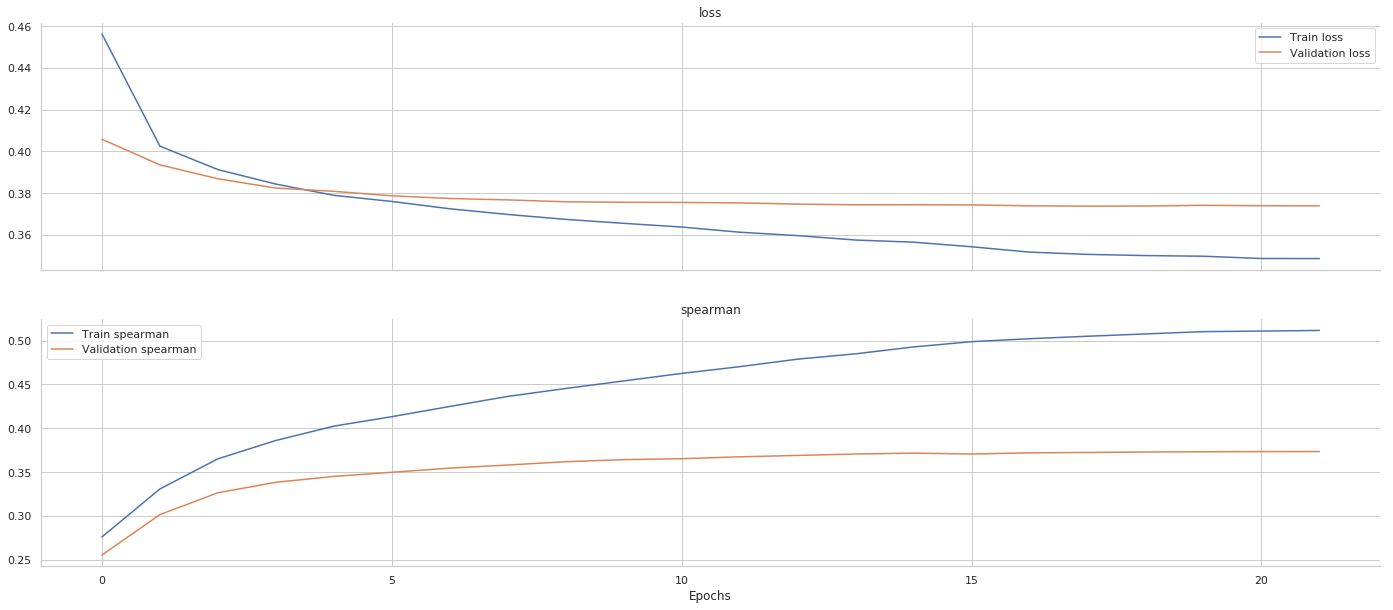

In [10]:
sns.set(style="whitegrid")
plot_metrics(history, metric_list=['loss', 'spearman'])

# Evaluation

In [11]:
preds_train = model.predict(X_train)
preds_val = model.predict(X_valid)

display(get_metrics(Y_train, preds_train, Y_valid, preds_val, target_cols))

,Label,Train,Validation
0,Averaged,0.512,0.373
1,question_asker_intent_understanding,0.470,0.400
2,question_body_critical,0.714,0.625
3,question_conversational,0.470,0.406
4,question_expect_short_answer,0.558,0.275
5,question_fact_seeking,0.606,0.356
6,question_has_commonly_accepted_answer,0.620,0.440
7,question_interestingness_others,0.423,0.386
8,question_interestingness_self,0.579,0.524
9,question_multi_intent,0.656,0.464


## By category

In [12]:
target_cols_preds = [col+'_pred' for col in target_cols]
for col in target_cols_preds:
    train[col] = 0
    validation[col] = 0
    
train[target_cols_preds] = preds_train
validation[target_cols_preds] = preds_val
    
display(get_metrics_category(train, validation, target_cols, target_cols_preds, 'category'))

,Label,Train (TECHNOLOGY),Validation (TECHNOLOGY),Train (SCIENCE),Validation (SCIENCE),Train (STACKOVERFLOW),Validation (STACKOVERFLOW),Train (LIFE_ARTS),Validation (LIFE_ARTS),Train (CULTURE),Validation (CULTURE)
0,Averaged,0.484,0.341,0.525,0.374,0.422,0.201,0.529,0.399,0.528,0.378


#### Save model weights and ecoders

In [13]:
model.save_weights(model_path)
dump(ohe_category, category_encoder_path)
dump(scaler, scaler_path)

['/kaggle/working/scaler.joblib']